# Installing required libraries


In [1]:
# Enforce pytorch version 1.6.0
import torch
if torch.__version__ != '1.6.0':
  !pip uninstall torch -y
  !pip uninstall torchvision -y
  !pip install torch==1.6.0
  !pip install torchvision==0.7.0

# Check pytorch version and make sure you use a GPU Kernel
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!python --version
!nvidia-smi

Found existing installation: torch 1.10.0+cu111
Uninstalling torch-1.10.0+cu111:
  Successfully uninstalled torch-1.10.0+cu111
Found existing installation: torchvision 0.11.1+cu111
Uninstalling torchvision-0.11.1+cu111:
  Successfully uninstalled torchvision-0.11.1+cu111
     |████████████████████████████████| 748.8 MB 17 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 1.0.61 requires torchvision, which is not installed.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.6.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.6.0 which is incompatible.


     |████████████████████████████████| 5.9 MB 32.1 MB/s 
1.6.0
10.2
Python 3.7.12
Mon Feb 14 18:01:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
     

In [ ]:
# If something breaks in the notebook it is probably related to a mismatch between the Python version, CUDA or torch
import torch
pytorch_version = f"torch-{torch.__version__}+cu{torch.version.cuda.replace('.', '')}.html"
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install torch-geometric

# Connecting to goole drive and freezing project path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Reading the file
project_path='drive/MyDrive/Colab Notebooks/Graphs'
filename='/lat_long - lat_long.csv'
import pandas as pd
cordinates=pd.read_csv(project_path+filename)

In [5]:
cordinates.head()

,Id,latitude,longitude
0,0,87.333294,144.484409
1,1,-22.605420,143.376342
2,2,-43.531545,-78.595627
3,3,-50.787744,-8.422739
4,4,-49.270064,-62.172244


In [33]:
# Dropping nearby locations
import numpy as np
df=np.round(cordinates,0)
df.drop(df.columns[0],axis=1,inplace=True)
df.drop(df[df.duplicated()].index,axis=0,inplace=True)

cordinates=cordinates.iloc[df.index]
cordinates.drop(cordinates.columns[0],axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [39]:
# Using KMeans clustering to find the ideal number of clusters
from tqdm import tqdm
df=np.round(cordinates,0)
from sklearn.cluster import KMeans
inertias=[]
index=[]
for i in tqdm(range(5,50)):
  km=KMeans(n_clusters=i)
  km.fit(df)
  inertias.append(km.inertia_)
  index.append(i)


100%|██████████| 45/45 [06:10<00:00,  8.23s/it]


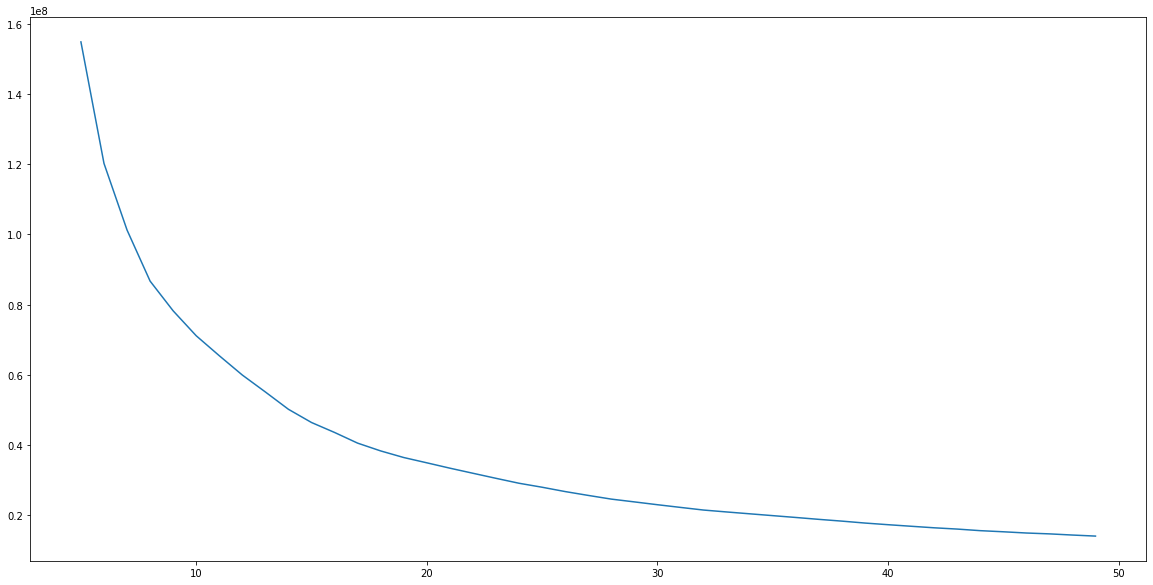

In [40]:
# Elbow method to find ideal number of cluster
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(index,inertias)



In [41]:
# Creating a Kmeans clustering with 18 clusters
df=np.round(cordinates,0)
km=KMeans(n_clusters=20,random_state=1)
km.fit(df)
df['cluster']=km.predict(cordinates)
df['cluster']=df['cluster'].astype('object')

In [42]:
df.head()

,latitude,longitude,cluster
0,87.0,144.0,17
1,-23.0,143.0,1
2,-44.0,-79.0,15
3,-51.0,-8.0,4
4,-49.0,-62.0,15


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


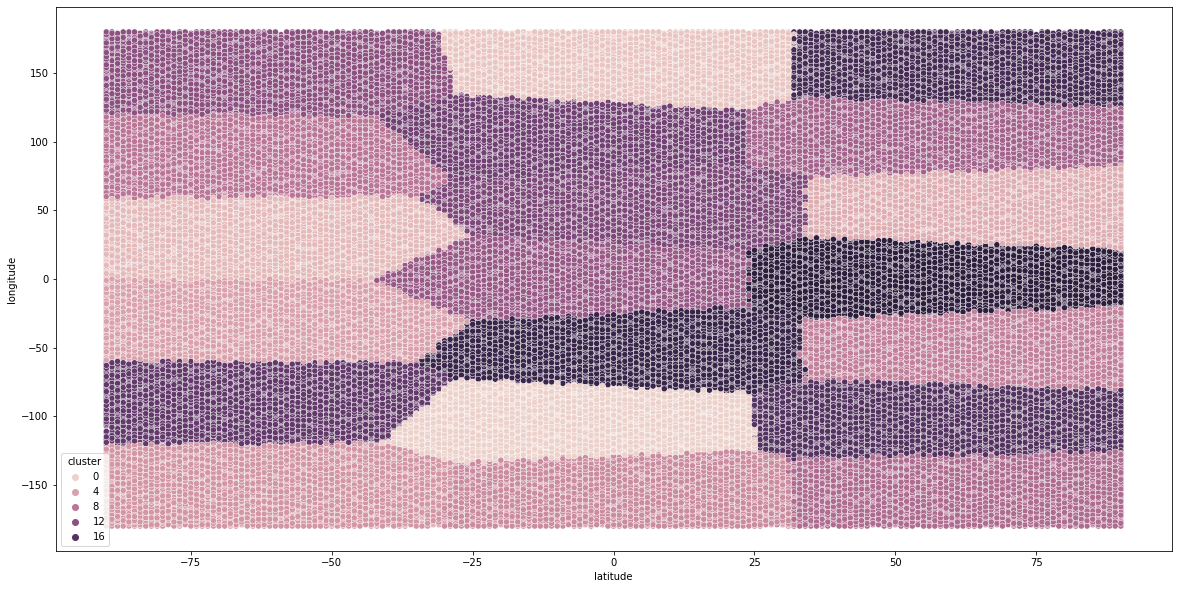

In [46]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.scatterplot(df['latitude'],df['longitude'],df['cluster'])

# Converting the CSV file into Pytorch geometry

In [56]:

from tqdm import tqdm
x=[]
for i,row in tqdm(df.iterrows()):
  value=[row['latitude'],row['longitude']]
  x.append(value)
x= torch.tensor(x)

63807it [00:05, 11293.32it/s]


In [57]:
from torch_geometric.data import Data
data=Data(x=x) # The values of nodes are latitudes and longitudes

In [54]:
# Checking the values in nodes
data.x[0:3]

[[87.0, 144.0], [-23.0, 143.0], [-44.0, -79.0]]